In [151]:
path2train = "/home/e209440/data/train"
path2test = "/home/e209440/data/test"
path2redux_data = "/home/r120084/project/data/redux/my_distract_driver_data_redux.npy"

In [152]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch as tc
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import transforms, utils

from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm 
import random

random.seed(7)

In [153]:
import os, glob, math,time
from scipy import misc

In [154]:
img_size = 50
sz = (img_size, img_size)
'''
labels = {'c0' : 'safe driving', 
'c1' : 'texting - right', 
'c2' : 'talking on the phone - right', 
'c3' : 'texting - left', 
'c4' : 'talking on the phone - left', 
'c5' : 'operating the radio', 
'c6' : 'drinking', 
'c7' : 'reaching behind', 
'c8' : 'hair and makeup', 
'c9' : 'talking to passenger'}
'''
labels = {'c0' : 'safe driving', 'c1' : 'texting - right'}  #only if you want to load only few labels

few_samples = True
if few_samples:
    n_samples = 100

In [155]:
def process_image(img_file, sz):
    img = misc.imread(img_file)
    img = misc.imresize(img, sz).transpose((2,0,1)).astype('float32') / 255.0
    #img = img.transpose((2,0,1)).astype('float32') / 255.0
    return img

In [156]:
def load_traindata(path, labels, sz):
    print('Load train dataset...')
    X_train= []
    Y_train = []
    for j in tqdm(labels):
        path_folder = os.path.join(path, str(j), '*.jpg')
        files = glob.glob(path_folder)
        X_train.extend(process_image(im_file, sz) for im_file in files)
        Y_train.extend([int(j[-1])]*len(files))
        
    X_train = np.array(X_train)
    Y_train = np.array(Y_train)
    return [X_train,Y_train]

In [157]:
def load_testdata(path):
    print('Load test dataset...')
    X_test    = []
    X_test_id = []
    
    # This is a stub function it must be completed
    
    '''
    path  = os.path.join(path2test, '*.jpg')
    files = glob.glob(path)

    idx = 0
    for im_file in tqdm(files):
        idx+=1
        if idx==20:
            break
        X_test.extend(process_image(im_file))    
        results = process_image(im_file)
        
    X_test = np.array(X_test)
    X_test = tc.from_numpy(X_test).type(tc.FloatTensor)
    '''
    
    return [X_test, X_test_id]

In [158]:
def get_driver_data(path2train, path2test, labels, sz):
    
    X_train, Y_train = load_traindata(path2train, labels, sz)
    X_test, X_test_id = load_testdata(path2test)
    
    data = {}
    data['X_train'] = X_train
    data['Y_train'] = Y_train
    data['X_test'] = X_test
    data['X_test_id'] = X_test_id
    return data

In [159]:
data = get_driver_data(path2train, path2test, labels, sz)

Load train dataset...


100%|██████████| 2/2 [00:43<00:00, 21.79s/it]


Load test dataset...


In [160]:
def slice_data(data, n_samples):
    lst = np.arange(0,data.shape[0])
    lst_sample = random.sample(list(lst), n_samples)
    try:
        return data[lst_sample,:,:,:]
    except:
        return data[lst_sample]

In [168]:
data_redux ={}
if few_samples:
    data_redux['X_train'] = slice_data(data['X_train'], 100)
    data_redux['Y_train'] = slice_data(data['Y_train'], 100)
    #data1['X_test'] = slice_data(data['X_test'], n_samples)
    #data1['X_test_id'] = slice_data(data['X_test_id'], n_samples)

In [169]:
# Save redux data
np.save('/home/r120084/project/data/redux/my_distract_driver_data_redux.npy', data_redux) 

In [170]:
# Load redux data
read_dictionary = np.load(path2redux_data).item()

In [172]:
def plot_classes(labels, X, Y, img_size):
    #plt.figure(figsize=(20,10))
    size_subp= len(labels)
    cnt=1
    for i in labels:
        plt.figure()
        ix = random.randint(0, len(np.where(Y==str(i))[0]))
        ind = np.where(Y==int(i[-1]))[0][ix]
        image = X[ind].reshape(3,img_size,img_size).transpose((1,2,0))
        #plt.subplot(5,2, cnt)
        plt.imshow(image, cmap=plt.cm.gray_r)
        plt.axis('off')
        plt.title(labels[i])
        cnt +=1

/home/adessowiki/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/home/adessowiki/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


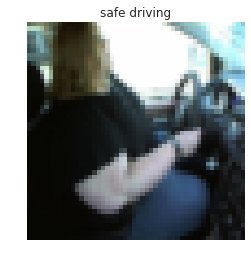

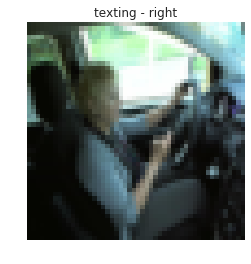

In [173]:
plot_classes(labels, data['X_train'], data['Y_train'], img_size)

In [174]:
# if you want to work with the redux data or not

redux = True

if redux:
    X_train = read_dictionary['X_train']
    Y_train = read_dictionary['Y_train']
    #X_test = read_dictionary['X_test']
    #X_test_id = read_dictionary['X_test_id']
else:
    X_train = data['X_train']
    Y_train = data['Y_train']
    #X_test = data['X_test']
    #X_test_id = data['X_test_id']

## Convert to tensor

In [177]:
def array2tensor(X_train, Y_train, X_test = [], X_test_id = []):
        
    X_train_tns = tc.from_numpy(X_train).type(tc.FloatTensor)
    Y_train_tns = tc.from_numpy(Y_train).type(tc.FloatTensor)
    #X_test_tns = tc.from_numpy(X_test).type(tc.FloatTensor)
    #X_test_id_tns = tc.from_numpy(X_test_id).type(tc.FloatTensor)
    #return [X_train_tns, Y_train_tns, X_test_id_tns, X_test_id_tns]
    return [X_train_tns, Y_train_tns]

In [178]:
X_train_tns, Y_train_tns = array2tensor(X_train, Y_train)

In [179]:
X_train_tns.shape, Y_train_tns.shape

(torch.Size([100, 3, 50, 50]), torch.Size([100]))

In [ ]:
class CRDataset(Dataset):
    
    def __init__(self, data, target, transform):
        assert data.shape[0] == target.shape[0]
        
        self.data = data
        self.target = torch.LongTensor(target.astype(int))
        self.transform = transform
    
    def __len__(self):
        return self.target.shape[0]
    
    def __getitem__(self, i):
        data = self.transform(self.data[i, :, :, :])
        return (data, self.target[i])